In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

2022-01-14 17:20:21.861160: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


In [2]:
os.listdir("../input/skin-cancer-malignant-vs-benign")

['data', 'test', 'train']

In [3]:
os.listdir("../input/skin-cancer-malignant-vs-benign/train")

['benign', 'malignant']

In [4]:
ben_dir = "../input/skin-cancer-malignant-vs-benign/train/benign"
malig_dir = "../input/skin-cancer-malignant-vs-benign/train/malignant"

train_dir = "../input/skin-cancer-malignant-vs-benign/train/"
test_dir = "../input/skin-cancer-malignant-vs-benign/test/"

In [5]:
print("Number of images in benign folder:",len(os.listdir("../input/skin-cancer-malignant-vs-benign/train/benign")))
print("Number of images in malignant folder:",len(os.listdir("../input/skin-cancer-malignant-vs-benign/train/malignant")))

Number of images in benign folder: 1440
Number of images in malignant folder: 1197


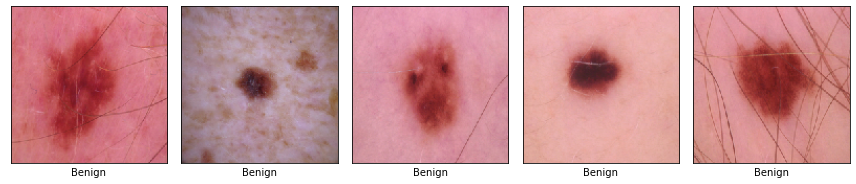

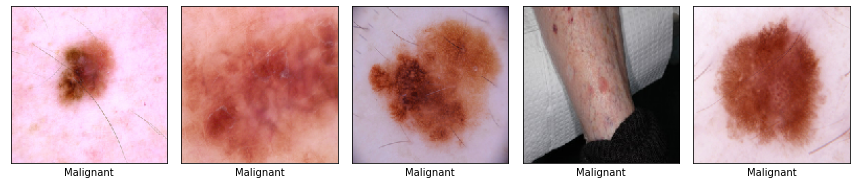

In [6]:
import random
import warnings
warnings.filterwarnings("ignore")
from tensorflow.keras.preprocessing.image import load_img
plt.figure(figsize=(12,7))
ben = random.sample(os.listdir(ben_dir),5)
malig = random.sample(os.listdir(malig_dir),5)

for i,img in enumerate(ben):
    path = os.path.join(ben_dir,img)
    img = load_img(path, target_size=(150,150))
    plt.subplot(1,5,i+1)
    plt.imshow(img)
    plt.xlabel("Benign")
    plt.xticks([])
    plt.yticks([])
plt.tight_layout();

plt.figure(figsize=(12,7))
for i,img in enumerate(malig):
    path = os.path.join(malig_dir,img)
    img = load_img(path, target_size=(150,150))
    plt.subplot(1,5,i+1)
    plt.imshow(img)
    plt.xlabel("Malignant")
    plt.xticks([])
    plt.yticks([])
plt.tight_layout();

In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale =(1./255),rotation_range=0.2,
    width_shift_range=0.2,
    shear_range=0.3,
    zoom_range=0.3,
    fill_mode='nearest',
    horizontal_flip= True)

val_datagen = ImageDataGenerator(rescale =(1./255))

train_data = train_datagen.flow_from_directory(directory = train_dir, 
                                               target_size =(224,224),
                                               class_mode = "binary",
                                               batch_size =32)
test_data = val_datagen.flow_from_directory(directory = test_dir, 
                                               target_size =(224,224),
                                               class_mode = "binary",
                                               batch_size =32)

Found 2637 images belonging to 2 classes.
Found 660 images belonging to 2 classes.


>Augmented Image:

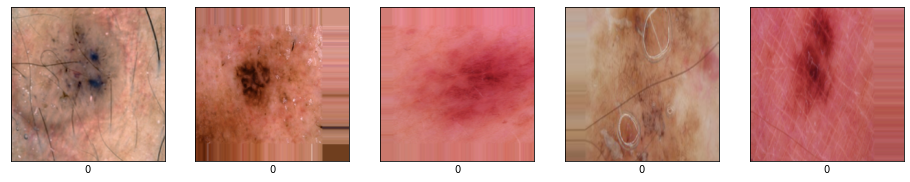

In [8]:
from tensorflow.keras.preprocessing import image
sample_x, sample_y = next(train_data)
plt.figure(figsize=(16,9))
for i in range(5):
    plt.subplot(1,5,i+1)
    img = image.img_to_array(sample_x[i])
    plt.imshow(img)
    plt.xlabel(np.argmax(sample_y[i]))
    plt.xticks([])
    plt.yticks([])
plt.show()

In [9]:
from tensorflow.keras.applications import DenseNet121
dense = DenseNet121(weights = "imagenet", include_top = False, input_shape=(224,224,3))

2022-01-14 17:20:29.658315: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-01-14 17:20:29.660874: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-01-14 17:20:29.701342: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-14 17:20:29.701958: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla P100-PCIE-16GB computeCapability: 6.0
coreClock: 1.3285GHz coreCount: 56 deviceMemorySize: 15.90GiB deviceMemoryBandwidth: 681.88GiB/s
2022-01-14 17:20:29.702042: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2022-01-14 17:20:29.727201: I tensorflow/stream_executor/platform/def

29089792/29084464 [==============================] - 0s 0us/step


In [10]:
for layer in dense.layers[:121]:
    layer.trainable = False

In [11]:
from tensorflow.keras import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D,GlobalAveragePooling2D, Flatten, Dropout, BatchNormalization

model = Sequential()
model.add(dense)
model.add(MaxPooling2D())
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Flatten())
model.add(Dense(512,activation= "relu"))
model.add(Dropout(0.5))
model.add(Dense(1, activation = "sigmoid"))

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet121 (Functional)     (None, 7, 7, 1024)        7037504   
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 3, 3, 1024)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 3, 3, 1024)        4096      
_________________________________________________________________
dropout (Dropout)            (None, 3, 3, 1024)        0         
_________________________________________________________________
flatten (Flatten)            (None, 9216)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               4719104   
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0

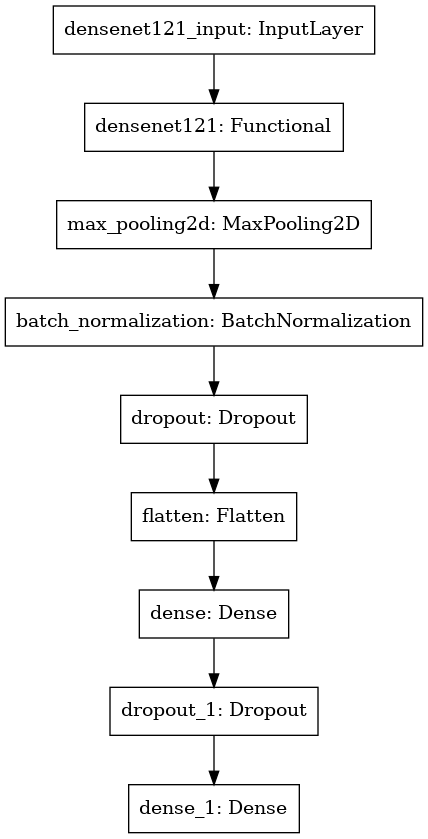

In [13]:
plot_model(model,
    to_file='DenseNet.png',
    show_shapes=False,
    show_layer_names=True)

In [14]:
import tensorflow_addons as tfa
from tensorflow.keras import metrics
from tensorflow_addons.metrics import F1Score
from tensorflow.keras.optimizers import Adam
from tensorflow_addons.metrics import MatthewsCorrelationCoefficient
metrics = ['accuracy',
           metrics.Precision(name='precision'),
           metrics.Recall(name='recall'),
           F1Score(num_classes = 1,name = 'f1'),
           MatthewsCorrelationCoefficient(num_classes = 1,name='mc'),
           tf.keras.metrics.TruePositives(name= 'tp'),
           tf.keras.metrics.TrueNegatives(name = 'tn'),
           tf.keras.metrics.FalseNegatives(name = 'fn'),
           tf.keras.metrics.FalsePositives(name = 'fp')
          ]

lr=0.001
model.compile(optimizer = Adam(lr = 0.001), loss = "binary_crossentropy", metrics = metrics)

In [15]:
patience = 1
stop_patience = 3
factor = 0.5
#    tf.keras.callbacks.EarlyStopping(patience=stop_patience, monitor='val_loss', verbose=1),
callbacks = [
    tf.keras.callbacks.ModelCheckpoint("densenet121.h5", save_best_only=True, verbose = 0),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=factor, patience=patience, verbose=1)
]

In [16]:
history = model.fit(train_data, validation_data = test_data, epochs = 15, 
                    verbose = 1, callbacks = callbacks )

2022-01-14 17:20:37.823527: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-01-14 17:20:37.827890: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2000194999 Hz


Epoch 1/15


2022-01-14 17:20:48.295983: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2022-01-14 17:20:49.167991: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.11
2022-01-14 17:20:49.233601: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.8


83/83 [==============================] - 74s 694ms/step - loss: 0.8080 - accuracy: 0.7636 - precision: 0.7384 - recall: 0.7348 - f1: 0.6235 - mc: 0.4746 - tp: 464.3452 - tn: 585.4405 - fn: 145.0119 - fp: 148.7619 - val_loss: 13.6582 - val_accuracy: 0.4848 - val_precision: 0.4681 - val_recall: 0.9767 - val_f1: 0.6276 - val_mc: 0.3306 - val_tp: 293.0000 - val_tn: 27.0000 - val_fn: 7.0000 - val_fp: 333.0000
Epoch 2/15
83/83 [==============================] - 36s 437ms/step - loss: 0.3496 - accuracy: 0.8311 - precision: 0.7920 - recall: 0.8545 - f1: 0.6501 - mc: 0.4768 - tp: 517.0476 - tn: 615.7738 - fn: 94.5833 - fp: 126.3333 - val_loss: 0.9067 - val_accuracy: 0.7697 - val_precision: 0.9353 - val_recall: 0.5300 - val_f1: 0.7989 - val_mc: 0.5674 - val_tp: 159.0000 - val_tn: 349.0000 - val_fn: 141.0000 - val_fp: 11.0000
Epoch 3/15
83/83 [==============================] - 36s 439ms/step - loss: 0.2805 - accuracy: 0.8678 - precision: 0.8456 - recall: 0.8683 - f1: 0.6528 - mc: 0.4774 - tp: 531

In [17]:
model.save("densenet121.h5")
model.evaluate(test_data)

21/21 [==============================] - 2s 97ms/step - loss: 0.2660 - accuracy: 0.9242 - precision: 0.9085 - recall: 0.9267 - f1: 0.7299 - mc: 0.5125 - tp: 278.0000 - tn: 332.0000 - fn: 22.0000 - fp: 28.0000


[0.26598164439201355,
 0.9242424368858337,
 0.9084967374801636,
 0.9266666769981384,
 array([0.729927], dtype=float32),
 array([0.51245004], dtype=float32),
 278.0,
 332.0,
 22.0,
 28.0]

In [18]:
import itertools
y_pred = model.predict(test_data)
#y_pred = np.argmax(y_pred, axis=1)
y_pred = list(itertools.chain.from_iterable(y_pred))

pred = []
def prediction(label):
    for i in label:
        if i > 0.5:
            pred.append(1)
        else:
            pred.append(0)
    return pred
       
predict = prediction(y_pred) #predict = 
print(predict)

[1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 

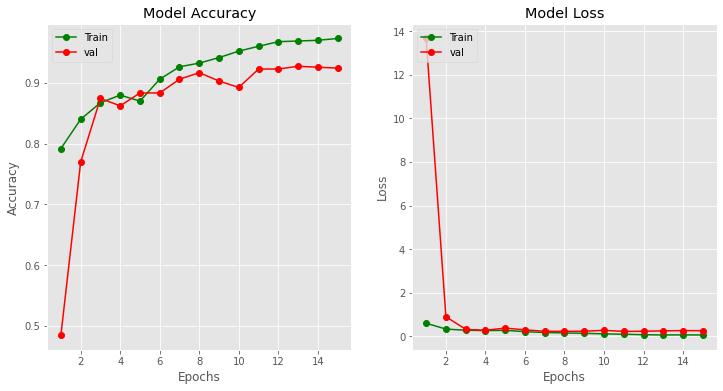

In [19]:
plt.style.use("ggplot")
fig = plt.figure(figsize=(12,6))
epochs = range(1,16)
plt.subplot(1,2,1)
plt.plot(epochs,history.history["accuracy"],"go-")
plt.plot(epochs,history.history["val_accuracy"],"ro-")
plt.title("Model Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Train","val"],loc = "upper left")
#plt.show()

plt.subplot(1,2,2)
plt.plot(epochs,history.history["loss"],"go-")
plt.plot(epochs,history.history["val_loss"],"ro-")
plt.title("Model Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Train","val"],loc = "upper left")
plt.show()

In [20]:
test_data.labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

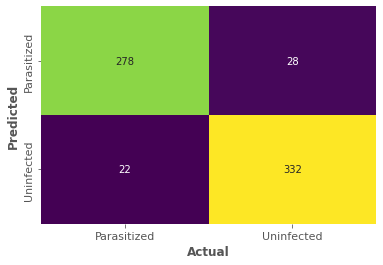

In [21]:
import seaborn as sns
cm_data = [[history.history['val_tp'][-1], history.history['val_fp'][-1]], [history.history['val_fn'][-1], history.history['val_tn'][-1]]]
sns.heatmap(cm_data, annot=True, cmap = 'viridis',cbar = False,fmt = 'g')
plt.xticks([0.5,1.5],["Parasitized","Uninfected"],fontsize=11)
plt.yticks([0.5,1.5],["Parasitized","Uninfected"],fontsize=11)
plt.xlabel("Actual",fontsize=12, fontweight="bold")
plt.ylabel("Predicted",fontsize=12, fontweight="bold")
plt.show()